In [1]:
#import data
import pandas as pd
import numpy as np

data = pd.read_csv("output_site_10292.csv") 
data

,Hot Water Outlet Temperature (C),Hot Water Average Temperature (C),T_WH3 Temperature (C),T_WH10 Temperature (C),Draw Data (L),Setpoint (C)
0,39.381536,39.410586,39.416438,39.416438,0.000000,45.560
1,39.314832,39.374383,39.386470,39.386470,0.000000,45.560
2,39.341707,39.338256,39.356371,39.356536,0.000000,45.560
3,39.273645,39.302194,39.325276,39.326631,0.000000,45.560
4,39.206348,39.266208,39.294286,39.296749,0.000000,45.560
...,...,...,...,...,...,...
844795,57.724538,53.616353,57.893100,52.972531,0.000000,56.768
844796,57.743445,53.557123,57.796905,52.840995,0.000000,53.940
844797,57.698999,53.497966,57.738174,52.710509,0.000000,53.940
844798,57.568121,52.931158,57.678653,51.378016,0.252361,53.940


Input: Ochre Equipment Reading Output
Trains Regression models based on 15 minute increments of , Node Temp, Draw Data, and Setpoint

In [4]:
#Data transformation, Y-values are y_i+1 temperatures for the next hour
def rolling_subsets(input_list, window_size = 4):
    if window_size > len(input_list) or window_size <= 0:
        raise ValueError("Window size must be positive and not greater than the list length.")
    
    return [input_list[i:i + window_size] for i in range(len(input_list) - window_size + 1)]

import numpy as np

def csv_to_features(df, include=True, interaction=False): #exports features, y = 15 minute increment predictions for 1 hour of outlet temperature
    #x = 15 minute increment predictions for setpoint and draw data, live readings for node temperature
    #include = True - includes node temperatures, x4/x5
    y_col = df["Hot Water Outlet Temperature (C)"]
    window = 8 #2 hours
    result = rolling_subsets(y_col, window)

    # Create feature vectors
    x1 = df["Hot Water Average Temperature (C)"]
    x2 = rolling_subsets(df["Draw Data (L)"], window)
    x3 = rolling_subsets(df["Setpoint (C)"], window)
    x4 = df["T_WH3 Temperature (C)"]
    x5 = df["T_WH10 Temperature (C)"]

    print(len(y_col), len(x2), len(x2))

    y = result[1:]  # Remove the first index to offset, y = i+1th prediction
    x1_v = x1[:-window]  # Remove last 4
    x2_v = x2[:-1]
    x3_v = x3[:-1]
    x4_v = x4[:-window] #note temperatures should only be taken at current time interval (live readings)
    x5_v = x5[:-window]

    print(len(y), len(x1_v), len(x2_v), len(x3_v))

    # Stack features
    if include: #removing average temperature
        X = np.column_stack([x2_v, x3_v, x4_v, x5_v])
        print(x4_v[0], x5_v[0])
    else:
        X = np.column_stack([x1_v, x2_v, x3_v])

    return X, y


In [5]:
X, y = csv_to_features(data)
X[0]


844800 844793 844793
844792 844792 844792 844792
39.41643795734582 39.41643795734583


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.25236067,  0.        ,  0.        , 45.56      , 45.56      ,
       45.56      , 45.56      , 45.56      , 45.56      , 45.56      ,
       45.56      , 39.41643796, 39.41643796])

In [6]:
#Train test split 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train,y_train)
r_sq = model.score(X_train, y_train)
print(f"Training coefficient of determination: {r_sq}")
y_predict = model.predict(X_test)
test_r_sq = model.score(X_test, y_test)
print(f"Test coefficient of determination: {test_r_sq}")
mse = mean_squared_error(y_test, y_predict, multioutput='uniform_average')
print("Mean Squared Error:", mse)

Training coefficient of determination: 0.9536311397282237
Test coefficient of determination: 0.9542525917544937
Mean Squared Error: 1.4274533690956082


In [7]:
# get coefficients of model
#pd.DataFrame(zip(X_train.columns, model.coef_))
model.coef_

array([[ 6.25460712e-03, -4.17892614e-02,  1.45078700e-02,
        -1.48634945e-04, -1.65626542e-03, -3.98750475e-03,
        -4.01025626e-03, -2.94109852e-03,  5.57711947e-02,
        -4.12871628e-03, -1.92634527e-02,  2.89880654e-02,
         1.03839646e-02,  4.27543933e-03, -2.30155374e-02,
         3.62389037e-02,  8.88731644e-01, -5.14401545e-03],
       [ 2.77638753e-02, -1.05860217e-01, -2.05706913e-02,
         1.18870177e-02, -3.16097290e-04, -2.91305429e-03,
        -4.44793805e-03, -2.90759753e-03,  5.82682483e-02,
         8.68213266e-03, -1.62680675e-03,  1.01281922e-02,
         2.56916233e-02, -3.15834816e-03, -2.10446746e-02,
         3.55276442e-02,  8.62335223e-01, -1.88669920e-03],
       [ 1.51693643e-02, -9.01459209e-02, -8.54562993e-02,
        -2.29734523e-02,  1.15367862e-02, -1.38193182e-03,
        -2.81366406e-03, -3.30682336e-03,  7.02235590e-02,
        -5.10075210e-03,  2.07881191e-02,  2.28335826e-02,
         1.54431650e-02,  3.10435917e-03, -2.40048971e

In [8]:
error = (y_test[0] - y_predict[0]) / y_test[0]
#np.sum(error)/len(error)
error


46669   -0.016614
46670   -0.017186
46671   -0.014338
46672   -0.015125
Name: Hot Water Outlet Temperature (C), dtype: float64

In [8]:
#validation test
#val_data = pd.read_csv("output_site_10441.csv")
val_data = pd.read_csv("output_site_90023.csv")
X_val, y_val = csv_to_features(val_data)

844800 844793 844793
844792 844792 844792 844792
39.41643795734582 39.41643795734583


In [23]:
X_val[96 * 20 + 5]

array([ 0.        ,  0.        ,  0.        ,  0.        , 45.56      ,
       45.56      , 42.59466667, 40.        , 42.32417639, 34.28342511])

In [9]:
#error metrics
from sklearn.metrics import r2_score
y_predict_val = model.predict(X_val)

r_2_val = r2_score(y_val, y_predict_val)
print(f"test coefficient of determination: {r_2_val}")

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_val, y_predict_val, multioutput='uniform_average')
print("Mean Squared Error:", mse)

test coefficient of determination: 0.9208729317352525
Mean Squared Error: 2.187372130774257


In [62]:


print("Predicted Hot Water Outlet Temperature: " ) 
y_predict_val[1998]




Predicted Hot Water Outlet Temperature: 


array([36.2981995 , 35.95795367, 36.14971095, 36.13039349])

C:\Users\janel\AppData\Local\Temp\ipykernel_38264\3345921334.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = pd.date_range(start=start_time, end=end_time, freq="15T")
C:\Users\janel\AppData\Local\Temp\ipykernel_38264\3345921334.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Adjust values as needed


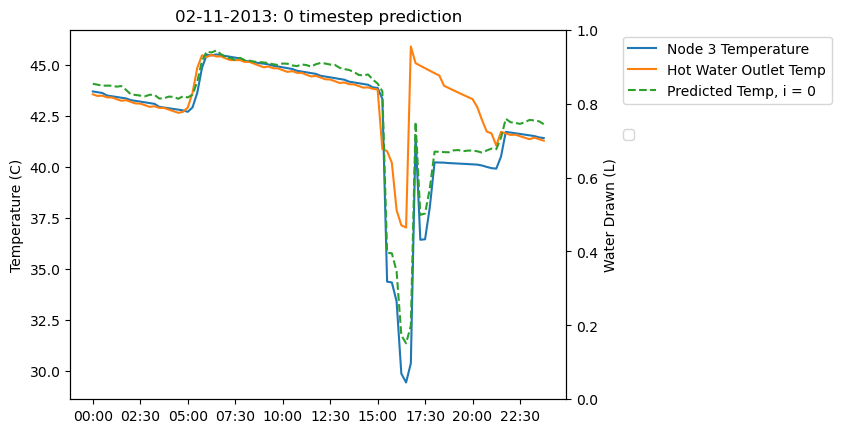

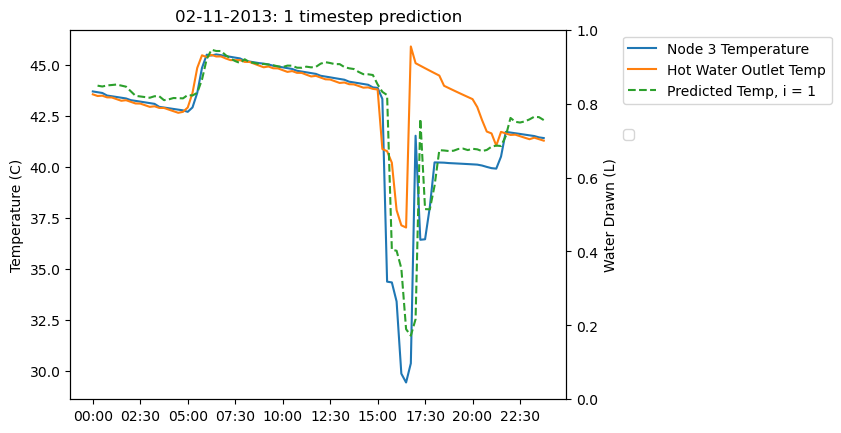

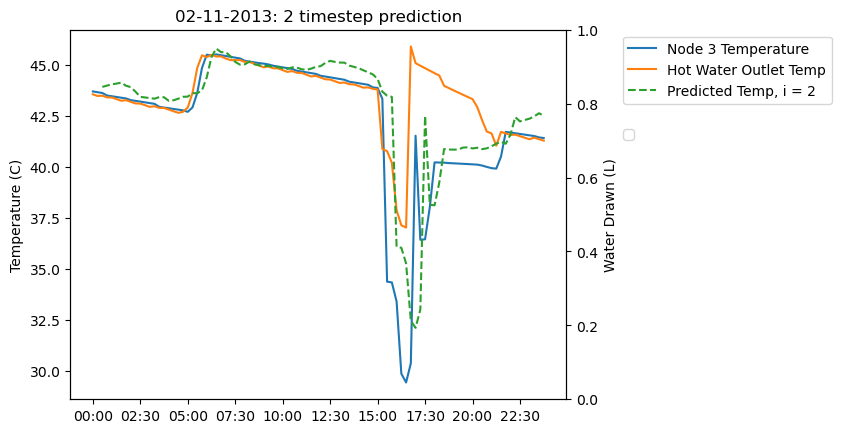

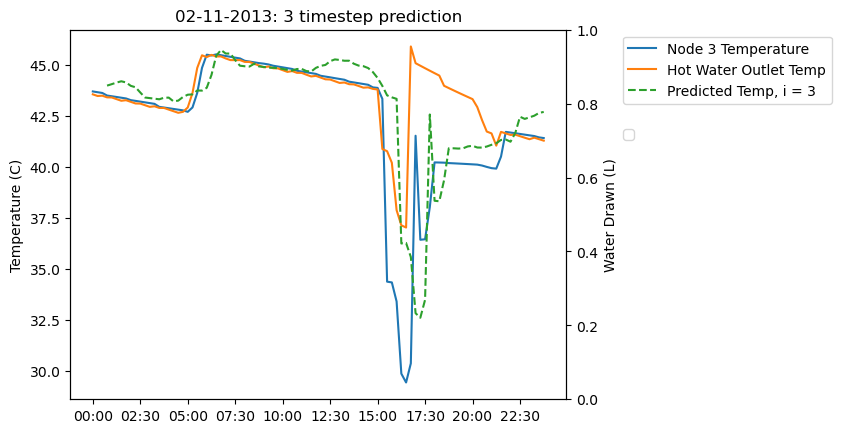

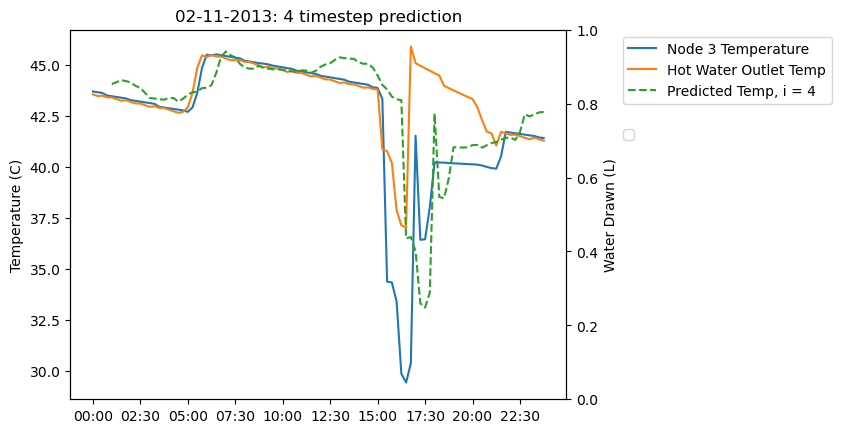

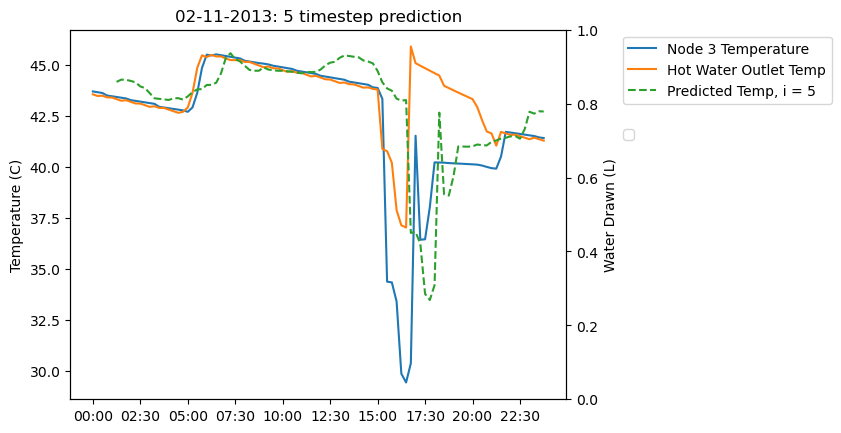

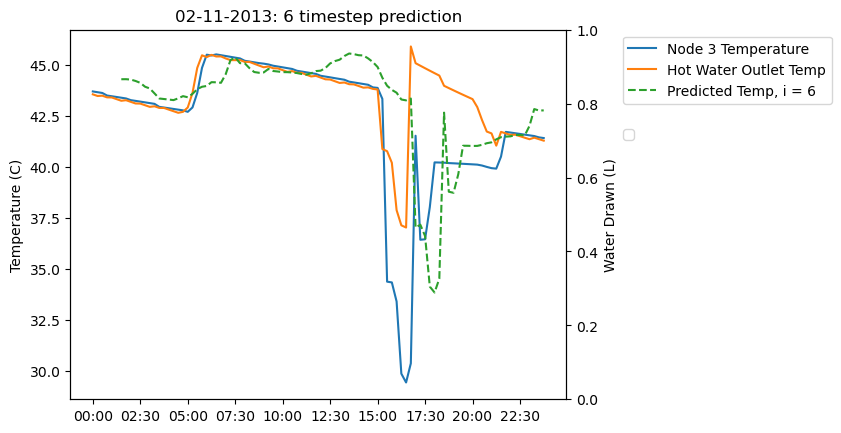

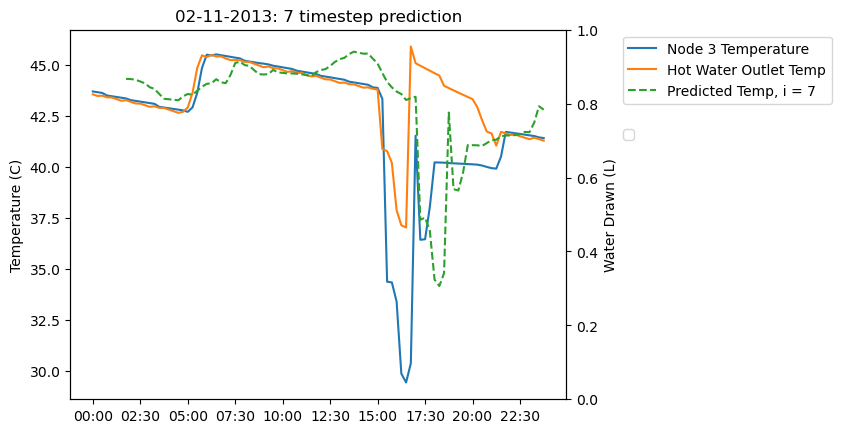

In [134]:
import matplotlib.pyplot as plt
#Create validation graphics

#get data for 1 day
#1440 minutes in a day / 15 = 96 windows in a day
days = {25}
window = 0
i = 8
for time_i in range(i):
    for day in days:
        x_day = X_val[(96*day):(96* day) + 96]
        #avg_temp_day = x_day[:, 0]
        draw_data_day = x_day[:, 0]
        setpoint_day = x_day[:, 8]
        node_3_temp_day = x_day[:, -2]
        node_10_temp_day = x_day[:, -1]
        y_day = y_val[(96 * day):(96 * day) + 96]
        y_day = [list(row) for row in zip(*y_day)]
        y_day = y_day[0]
        y_predict_day = y_predict_val[(96 * day):(96 * day) + 96]
        y_predict_day = y_predict_day[:, time_i]



    
        from datetime import datetime, timedelta
        
        #offset time by i time periods
        #start_time = "00:00:00"
        start_time = datetime(2013, 1, 1, 0, 0, 0)
        #start_time = datetime.strptime(start_time, "%H:%M:%S")
        #end_time = "23:59:59"
        end_time = datetime(2013, 1, 1, 23, 59, 59)
        # Create datetime range with 15-minute intervals
        datetime_list = pd.date_range(start=start_time, end=end_time, freq="15T")

        # Convert to a list (optional)
        datetime_list = list(datetime_list)
        datetime_list = [dt.strftime("%H:%M") for dt in datetime_list]

        # initializing day number

        
        day_num = str((day + 17) % 365)
        
        # adjusting day num
        day_num.rjust(3 + len(day_num), '0')
        
        # Initialize year
        year = "2013"
        
        # converting to date
        res = datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%m-%d-%Y")
        

        import matplotlib.dates as mdates
        plt.figure()
        #plt.plot(datetime_list, avg_temp_day, label = "Hot Water Avg Temp") #avg temp
        #plt.plot(datetime_list, setpoint_day, label = "Setpoint")
        plt.plot(datetime_list, node_3_temp_day, label = "Node 3 Temperature")
        #plt.plot(datetime_list, node_10_temp_day, label = "Node 10 Temperature")
        plt.plot(datetime_list, y_day, label = "Hot Water Outlet Temp")
        if time_i > 0:
            plt.plot(datetime_list[time_i:], y_predict_day[:-time_i], label = f"Predicted Temp, i = {time_i}", linestyle="dashed") #todo: add stagger of 15 minutes
        else:
            plt.plot(datetime_list, y_predict_day, label = f"Predicted Temp, i = {time_i}", linestyle="dashed") #todo: add stagger of 15 minutes
    
        plt.ylabel("Temperature (C)")
        plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))  # Adjust values as needed
        

        plt.twinx()
        #plt.plot(datetime_list, draw_data_day, label="Draw Data", color="blue", linestyle="dotted")
        plt.ylabel("Water Drawn (L)")
    
        plt.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Adjust values as needed

        plt.title(str(res)+ f": {time_i} timestep prediction")

        plt.xticks(datetime_list[::10])
        #plt.legend(loc='lower right')


In [92]:
datetime_list[time_i:]


['00:15',
 '00:30',
 '00:45',
 '01:00',
 '01:15',
 '01:30',
 '01:45',
 '02:00',
 '02:15',
 '02:30',
 '02:45',
 '03:00',
 '03:15',
 '03:30',
 '03:45',
 '04:00',
 '04:15',
 '04:30',
 '04:45',
 '05:00',
 '05:15',
 '05:30',
 '05:45',
 '06:00',
 '06:15',
 '06:30',
 '06:45',
 '07:00',
 '07:15',
 '07:30',
 '07:45',
 '08:00',
 '08:15',
 '08:30',
 '08:45',
 '09:00',
 '09:15',
 '09:30',
 '09:45',
 '10:00',
 '10:15',
 '10:30',
 '10:45',
 '11:00',
 '11:15',
 '11:30',
 '11:45',
 '12:00',
 '12:15',
 '12:30',
 '12:45',
 '13:00',
 '13:15',
 '13:30',
 '13:45',
 '14:00',
 '14:15',
 '14:30',
 '14:45',
 '15:00',
 '15:15',
 '15:30',
 '15:45',
 '16:00',
 '16:15',
 '16:30',
 '16:45',
 '17:00',
 '17:15',
 '17:30',
 '17:45',
 '18:00',
 '18:15',
 '18:30',
 '18:45',
 '19:00',
 '19:15',
 '19:30',
 '19:45',
 '20:00',
 '20:15',
 '20:30',
 '20:45',
 '21:00',
 '21:15',
 '21:30',
 '21:45',
 '22:00',
 '22:15',
 '22:30',
 '22:45',
 '23:00',
 '23:15',
 '23:30',
 '23:45']

C:\Users\janel\AppData\Local\Temp\ipykernel_28148\3873029130.py:34: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = pd.date_range(start=start_time, end=end_time, freq="15T")


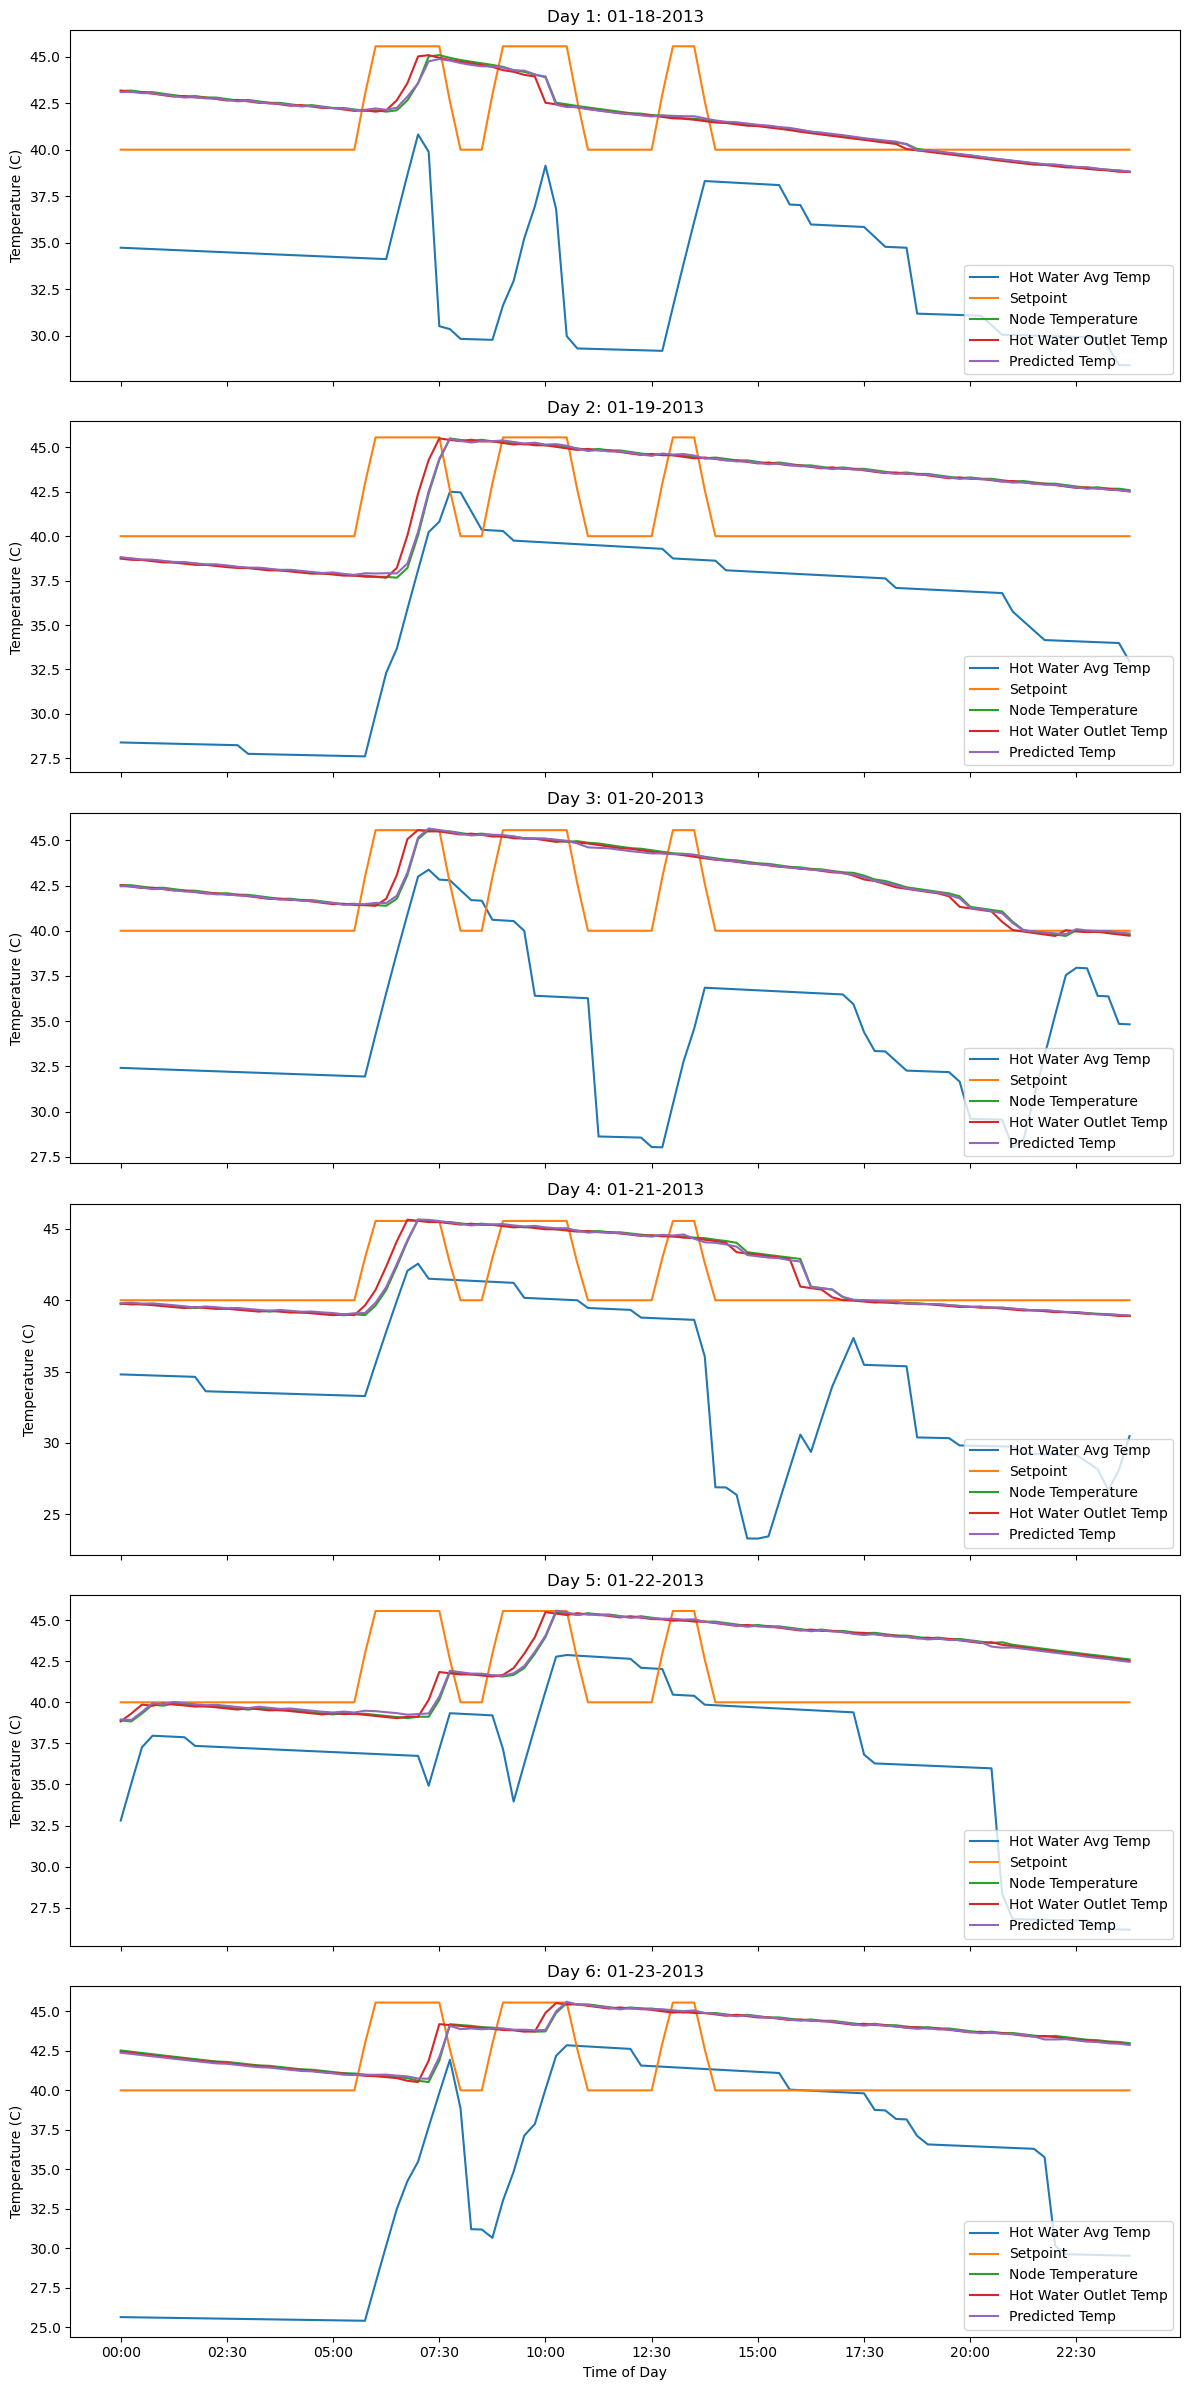

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime

# Define the days to visualize
days = {1, 2, 3, 4, 5, 6}

# Create a figure with subplots (rows for each day)
fig, axes = plt.subplots(len(days), 1, figsize=(12, 4 * len(days)), sharex=True)

# Ensure axes is always iterable (even for a single subplot)
if len(days) == 1:
    axes = [axes]

for i, day in enumerate(days):
    x_day = X_val[(96 * day):(96 * day) + 96]
    avg_temp_day = x_day[:, 0]
    draw_data_day = x_day[:, 1]
    setpoint_day = x_day[:, 5]
    node_temp_day = x_day[:, 9]

    y_day = y_val[(96 * day):(96 * day) + 96]
    y_day = [list(row) for row in zip(*y_day)]
    y_day = y_day[0]

    y_predict_day = y_predict_val[(96 * day):(96 * day) + 96]
    y_predict_day = y_predict_day[:, 0]

    start_time = "00:00:00"
    end_time = "23:59:59"

    # Create datetime range with 15-minute intervals
    datetime_list = pd.date_range(start=start_time, end=end_time, freq="15T")
    datetime_list = [dt.strftime("%H:%M") for dt in datetime_list]

    # Format date for the title
    day_num = str((day + 17) % 365).rjust(3, '0')
    year = "2013"
    res = datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%m-%d-%Y")

    # Plot each day's data in a separate row
    ax = axes[i]
    ax.plot(datetime_list, avg_temp_day, label="Hot Water Avg Temp")
    ax.plot(datetime_list, setpoint_day, label="Setpoint")
    ax.plot(datetime_list, node_temp_day, label="Node Temperature")
    ax.plot(datetime_list, y_day, label="Hot Water Outlet Temp")
    ax.plot(datetime_list, y_predict_day, label="Predicted Temp")

    ax.set_title(f"Day {day}: {res}")
    ax.set_ylabel("Temperature (C)")
    ax.legend(loc="lower right")

# Set common x-axis labels
axes[-1].set_xticks(datetime_list[::10])
axes[-1].set_xlabel("Time of Day")

# Improve layout
plt.tight_layout()
plt.show()


In [ ]:
# We set Hot Water Outlet as our predicted value
import numpy as np
from sklearn.linear_model import LinearRegression

#Linear Regression
model = LinearRegression()
model.fit(X,y)
r_sq = model.score(X, y)
print(f"coefficient of determination: {r_sq}")


coefficient of determination: 0.9860939061394864


In [63]:
from sklearn.linear_model import Lasso
#Lasso 
lasso = Lasso(alpha=1.0) # alpha is the regularization strength
lasso.fit(X, y)
lasso.score(X, y)

0.9857133554804913

In [ ]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)
clf.fit(X, y)
clf.score(X, y)

0.9860939061394838

: 

In [82]:
X_val[-180]
#y_val[-180]


array([ 0.        ,  0.        ,  0.        ,  0.        , 59.5       ,
       59.5       , 59.5       , 59.5       , 53.04471753, 52.6019025 ])

Model Coefficients: 
        [6.25460712e-03, -4.17892614e-02,  1.45078700e-02,
        -1.48634945e-04, -1.65626542e-03, -3.98750475e-03,
        -4.01025626e-03, -2.94109852e-03,  5.57711947e-02,
        -4.12871628e-03, -1.92634527e-02,  2.89880654e-02,
         1.03839646e-02,  4.27543933e-03, -2.30155374e-02,
         3.62389037e-02,  8.88731644e-01, -5.14401545e-03],
       [ 2.77638753e-02, -1.05860217e-01, -2.05706913e-02,
         1.18870177e-02, -3.16097290e-04, -2.91305429e-03,
        -4.44793805e-03, -2.90759753e-03,  5.82682483e-02,
         8.68213266e-03, -1.62680675e-03,  1.01281922e-02,
         2.56916233e-02, -3.15834816e-03, -2.10446746e-02,
         3.55276442e-02,  8.62335223e-01, -1.88669920e-03],
       [ 1.51693643e-02, -9.01459209e-02, -8.54562993e-02,
        -2.29734523e-02,  1.15367862e-02, -1.38193182e-03,
        -2.81366406e-03, -3.30682336e-03,  7.02235590e-02,
        -5.10075210e-03,  2.07881191e-02,  2.28335826e-02,
         1.54431650e-02,  3.10435917e-03, -2.40048971e-02,
         3.66494045e-02,  8.33101551e-01, -6.40011120e-04],
       [ 1.45554257e-02, -1.02992719e-01, -7.26927208e-02,
        -8.71559240e-02, -2.41501580e-02,  1.04887660e-02,
        -9.67297381e-04, -1.65804673e-03,  6.88879367e-02,
         9.19088439e-03,  5.36748804e-03,  4.70129494e-02,
         2.61752238e-02, -5.04828100e-03, -1.96994873e-02,
         3.59765419e-02,  8.04262858e-01, -6.13514419e-04],
       [ 1.59764637e-02, -1.01098912e-01, -8.60682054e-02,
        -7.30539695e-02, -8.91306653e-02, -2.41711655e-02,
         9.82865577e-03,  9.01233712e-04,  7.23084279e-02,
         1.39040304e-03,  2.46988117e-02,  2.73744080e-02,
         5.47915173e-02,  1.55808149e-03, -2.48843906e-02,
         3.84811029e-02,  7.76249087e-01, -1.34175681e-03],
       [ 1.09900244e-02, -9.31684910e-02, -8.61747063e-02,
        -8.74173110e-02, -7.58464384e-02, -8.87446600e-02,
        -2.55574887e-02,  1.35911660e-02,  7.13763518e-02,
         5.28459399e-03,  1.57597437e-02,  4.81736747e-02,
         3.37768118e-02,  3.18487505e-02, -2.12764775e-02,
         3.71605419e-02,  7.50147713e-01, -2.54332914e-03],
       [ 1.18276710e-02, -8.88973975e-02, -7.75248347e-02,
        -8.69995610e-02, -8.98479955e-02, -7.42300517e-02,
        -9.07444324e-02, -1.85131922e-02,  7.31369099e-02,
        -4.88046871e-04,  2.37528100e-02,  3.57408749e-02,
         5.82218647e-02,  7.59767931e-03,  1.14982613e-02,
         3.83875961e-02,  7.25159239e-01, -4.14010272e-03],
       [ 2.61027990e-02, -8.31925185e-02, -7.55482374e-02,
        -8.09662976e-02, -8.88863543e-02, -8.95595424e-02,
        -7.73536288e-02, -9.23762527e-02,  6.82204451e-02,
         7.10422024e-03,  1.44099871e-02,  4.60600721e-02,
         4.21294528e-02,  3.60398764e-02, -1.55777123e-02,
         7.32810268e-02,  7.01950982e-01, -5.62962301e-03]

Heavy draw example:
[ 9.58970533, 10.85150867,  0.50472133,  0.757082  , 40.        ,
       40.        , 40.        , 40.        , 35.62154299, 30.26831141])

In [54]:
import cvxpy as cp
import numpy as np

i = 4 #horizon
lambda_ = 1
l = 0.75 #soft constraint
n = 8
T_min = 49
T_max = 60

#example value
#model
M = np.array([[ 7.28633736e-03, -4.09192860e-02,  1.52439747e-02,
        -4.82169290e-04,    9.00829138e-01,
        -5.69097754e-03],
       [ 2.91175865e-02, -1.05376418e-01, -2.07084181e-02,
         1.20496174e-02,   8.74806479e-01,
        -2.38772625e-03],
       [ 1.71334030e-02, -8.92723554e-02, -8.47065548e-02,
        -2.01301912e-02,    8.45353501e-01,
        -1.15994386e-03],
       [ 1.67173613e-02, -1.03503935e-01, -7.13165816e-02,
        -8.96899573e-02,   8.17000521e-01,
        -1.11805105e-03]])

#setpoint model
N = np.array([[5.77093298e-02,  1.80417097e-04,
        -2.71496587e-02,  4.43406614e-02], 
        [5.79570719e-02,  1.75832801e-02,
        -1.75269655e-02,  3.97787407e-02], 
        [7.13945575e-02,  4.18339178e-04,
         1.09174019e-02,  4.27822306e-02], 
         [6.81606256e-02,  1.95253012e-02,
        -1.16657644e-02,  7.68034253e-02]])
x = [  9.58970533, 10.85150867,  0.50472133,  0.757082 , 35.62154299, 30.26831141 ]


# Construct the problem.
#declare variables
T = cp.Variable(i)
s = cp.Variable(i) #setpoint variables
z = cp.Variable(i)
objective = cp.Minimize(cp.sum(lambda_ * z**2 + (lambda_*l) * s))

constraints = [
    s >= T_min,
    s <= T_max,
    T == M @ x + N @ s,
    z >= T_min - T,
    z >= 0
    ]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()

# Print results
print("Optimal T values:", T.value)
print("Optimal s values:", s.value)
print("Optimal objective value:", result)

Optimal T values: [36.35332557 36.28441494 36.625918   37.2999594 ]
Optimal s values: [60. 60. 49. 60.]
Optimal objective value: 783.3833329199035
